CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:0000:0100:01


In [1]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [2]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')

categorical_columns = ['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range']
continuous_columns = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
target_columns = ['resale_price']

# TODO: Enter your code here
df_train = df[df['year'] <= 2019]
df_val = df[df['year'] == 2020]
df_test = df[df['year'] == 2021]

df_train = df_train.drop(categorical_columns, axis=1)
df_val = df_val.drop(categorical_columns, axis=1)
df_test = df_test.drop(categorical_columns, axis=1)

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [3]:
# Extract values from dataframes
X_train = df_train.drop(target_columns, axis=1).values
y_train = df_train[target_columns].values

X_val = df_val.drop(target_columns, axis=1).values
y_val = df_val[target_columns].values

X_test = df_test.drop(target_columns, axis=1).values
y_test = df_test[target_columns].values

# Convert values to tensors for model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

# Create custom DataLoaders
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(X_val, y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [4]:
input_size = X_train.shape[1]
output_size = 1
size_hidden = 5

class HDBRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(input_size, size_hidden)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden, size_hidden)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden, output_size)

    def forward(self, input):
        return self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))

In [5]:
model = HDBRegressionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [6]:
def train(model, optimizer, loss_fn, num_epochs, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = loss_fn(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()  

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                    (epoch + 1, num_epochs, running_loss))

train(model, optimizer, loss_fn, 30, dataloader_train)

Epoch [1]/[30] running accumulative loss across all batches: 215501032488960.000
Epoch [10]/[30] running accumulative loss across all batches: 15276448633856.000
Epoch [20]/[30] running accumulative loss across all batches: 12840569543680.000
Epoch [30]/[30] running accumulative loss across all batches: 10409042080512.000


In [7]:
# Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

no_of_test_instances = 1000 # using all test instances takes too long
sl_attr_test = sl.attribute(X_test[:no_of_test_instances])
ixg_attr_test = ixg.attribute(X_test[:no_of_test_instances])
ig_attr_test = ig.attribute(X_test[:no_of_test_instances], n_steps=50)
gs_attr_test = gs.attribute(X_test[:no_of_test_instances], X_train)
fa_attr_test = fa.attribute(X_test[:no_of_test_instances])

/Users/tohhongxiang/Desktop/programming/CZ4042-Assignment/venv/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


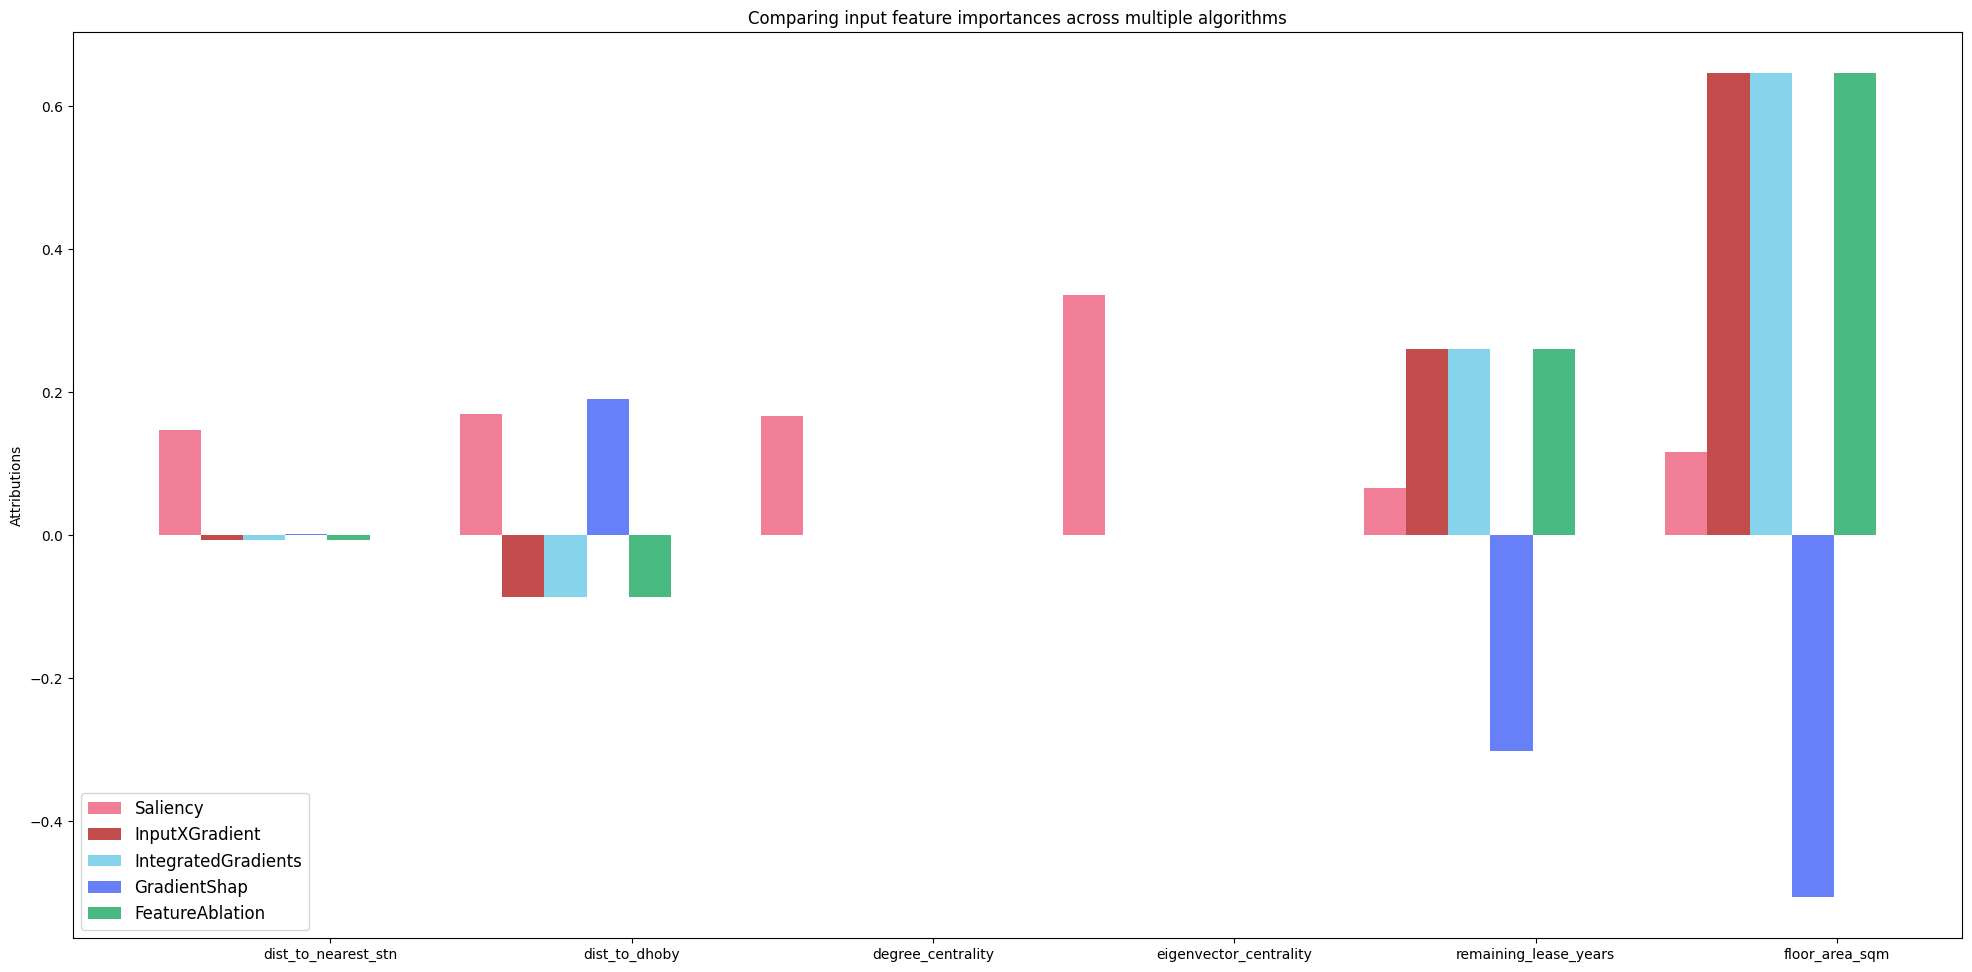

In [8]:
import matplotlib.pyplot as plt

# prepare attributions for visualization
feature_names = df_train.drop(target_columns, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sl_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [18]:
# TODO: Enter your code here
from sklearn.preprocessing import StandardScaler

# perform scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = torch.tensor(X_train_scaled).float()

X_val_scaled = scaler.transform(X_val)
X_val_scaled = torch.tensor(X_val_scaled).float()

X_test_scaled = scaler.transform(X_test)
X_test_scaled = torch.tensor(X_test_scaled).float()

# Create custom dataloaders for scaled data
batch_size = 64
dataset_train_scaled = torch.utils.data.TensorDataset(X_train_scaled, y_train)
dataloader_train_scaled = torch.utils.data.DataLoader(dataset_train_scaled, batch_size=batch_size, shuffle=True)

dataset_val_scaled = torch.utils.data.TensorDataset(X_val_scaled, y_val)
dataloader_val_scaled = torch.utils.data.DataLoader(dataset_val_scaled, batch_size=batch_size, shuffle=True)

dataset_test_scaled = torch.utils.data.TensorDataset(X_test_scaled, y_test)
dataloader_test_scaled = torch.utils.data.DataLoader(dataset_test_scaled, batch_size=batch_size, shuffle=True)

# Create model, optimizer and loss functions
model = HDBRegressionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train model on scaled data
train(model, optimizer, loss_fn, 30, dataloader_train_scaled)

Epoch [1]/[30] running accumulative loss across all batches: 216513482539008.000
Epoch [10]/[30] running accumulative loss across all batches: 151007005007872.000
Epoch [20]/[30] running accumulative loss across all batches: 33379471654912.000
Epoch [30]/[30] running accumulative loss across all batches: 9564199493376.000


In [20]:
# Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation
sl = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

no_of_test_instances = 1000 # using all test instances takes too long
sl_attr_test = sl.attribute(X_test_scaled[:no_of_test_instances])
ixg_attr_test = ixg.attribute(X_test_scaled[:no_of_test_instances])
ig_attr_test = ig.attribute(X_test_scaled[:no_of_test_instances], n_steps=50)
gs_attr_test = gs.attribute(X_test_scaled[:no_of_test_instances], X_train_scaled)
fa_attr_test = fa.attribute(X_test_scaled[:no_of_test_instances])

/Users/tohhongxiang/Desktop/programming/CZ4042-Assignment/venv/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


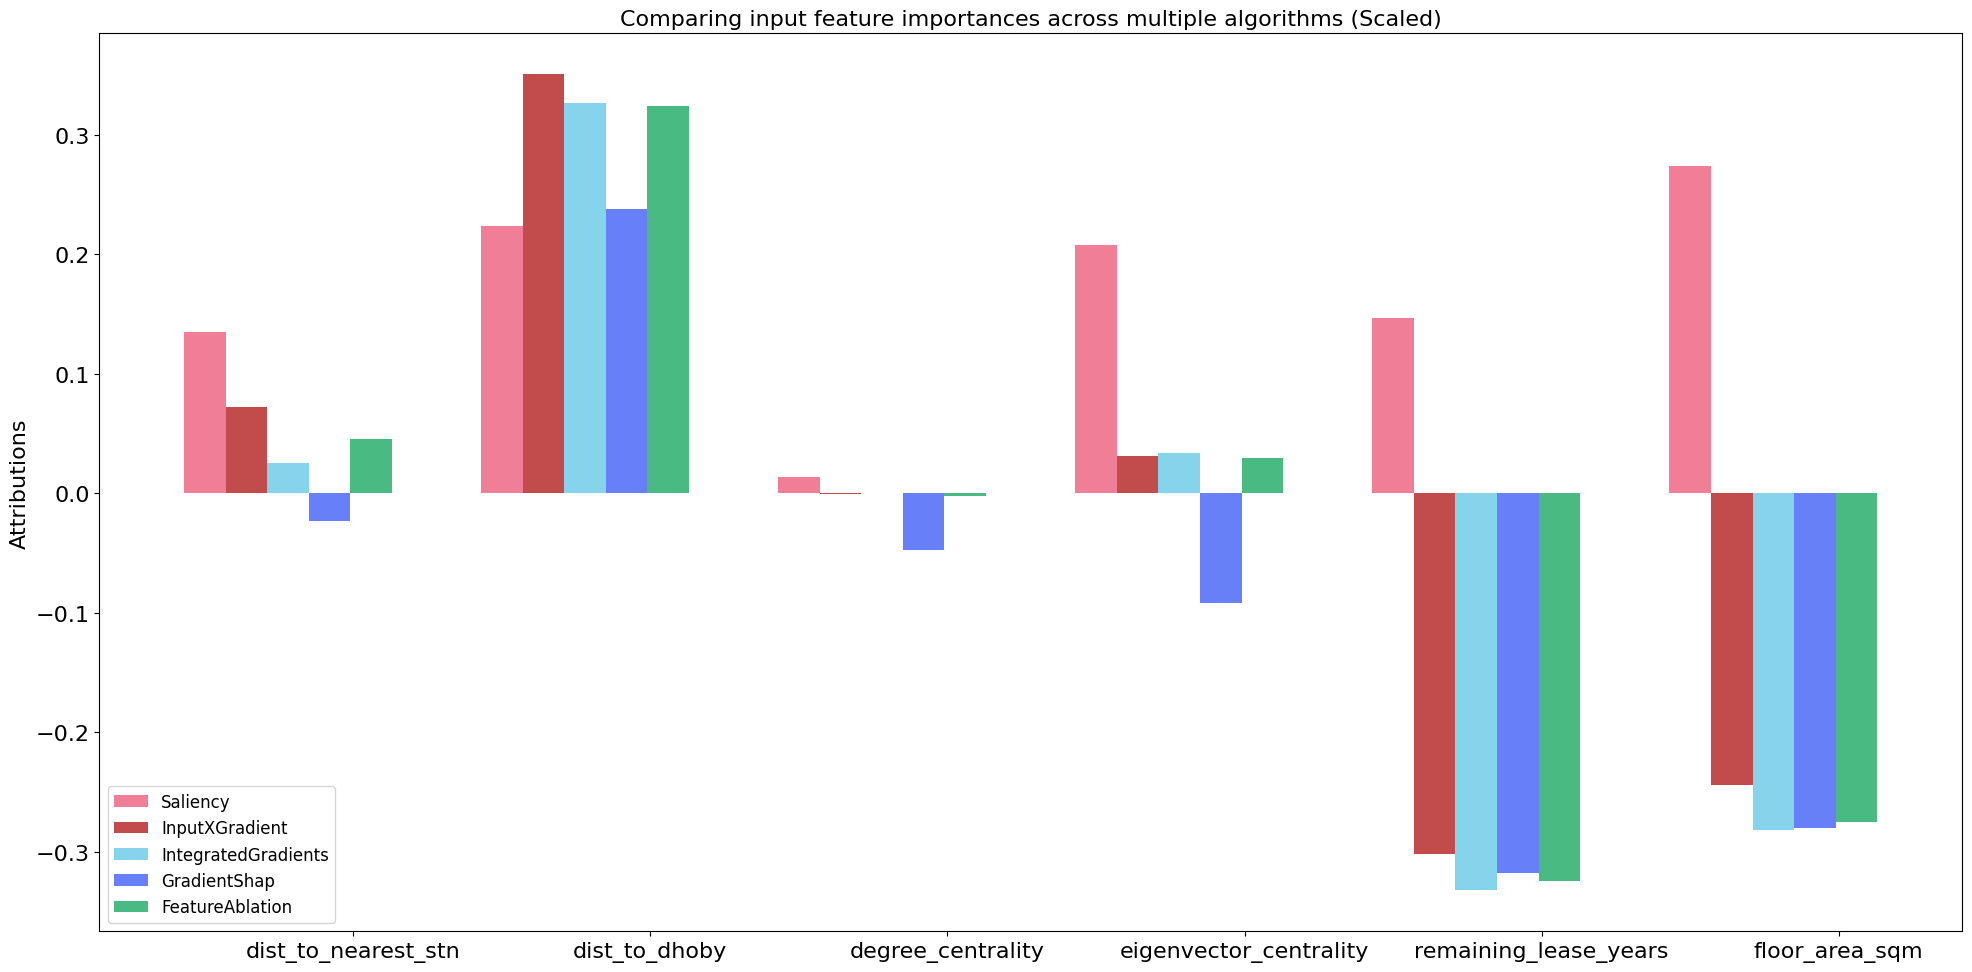

In [23]:
# prepare attributions for visualization
feature_names = df_train.drop(target_columns, axis=1).columns

x_axis_data = np.arange(X_test_scaled.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sl_attr_test_sum = sl_attr_test.detach().numpy().sum(0)
sl_attr_test_norm_sum = sl_attr_test_sum / np.linalg.norm(sl_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms (Scaled)')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sl_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In general, after standardisation, each feature has more impact on the final output, as shown by the increase in magnitude of GradientSHAP values

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?

Saliency is a measure of the gradients of the outputs wrt to the inputs, while IG is the integral of gradients along the path (straight line from baseline to input) and multiplies with (input - baseline)


> Why did Input x Gradients give the same attribution scores as IG?

Both Input x Gradients and IG provide a similar measure of how important a feature is to the final output. For IxG, we multiplied the gradients by the input value, while IG is just the integral of the fradients along the path from baseline to input